## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    if split=="train" or split=="validation":
        f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        
        if split == "train":
            inputs = inputs[:inputs.shape[0]*4//5]
        else:
            inputs = inputs[inputs.shape[0]*4//5:]
        
        f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        if split == "train":
            outputs = outputs[:outputs.shape[0]*4//5]
        else:
            outputs = outputs[outputs.shape[0]*4//5:]
    else:
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        outputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)
        else:
            #normalize start pos
            inp = self.inputs[idx]-data[0][0]
            out = self.outputs[idx]-data[0][0]
            data = (inp, out)

        return data
    
#     def split(self, split_ratio=0.2):
#         valid_size = round(split_ratio * len(self.inputs))
#         train_size = len(self.inputs) - valid_size

#         return random_split(self, [train_size, valid_size])

# intialize a dataset
city = 'palo-alto' 
split = 'train'
def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    #normalize start pos
    inp -= data[0][0]
    out -= data[0][0]
    return (inp, out)


## Create a DataLoader class for training

In [3]:
batch_sz = 32  # batch size
train_dataset  = ArgoverseDataset(city = city, split = split, transform=transform)
print(train_dataset[0][0][0:10])
train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
val_dataset = ArgoverseDataset(city = city, split = "validation")
print(val_dataset[0][0][0:10])
val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)

[[0.         0.        ]
 [0.24510359 0.40461129]
 [0.55047809 0.90658306]
 [0.91428859 1.50370546]
 [1.33260374 2.18832148]
 [1.80064386 2.95016006]
 [2.30665141 3.77068149]
 [2.83659709 4.62849695]
 [3.37963539 5.5048743 ]
 [3.92558779 6.38097759]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 2.89563301e-04  1.65998256e-05]
 [ 1.11227701e-03  1.36774919e-04]
 [ 1.52206047e-03  6.15368538e-05]
 [ 1.47052523e-03 -1.45599099e-04]
 [ 1.06749825e-03 -4.63029771e-04]
 [ 6.02289883e-04 -1.03492679e-03]
 [-5.97619235e-05 -1.85323801e-03]
 [-1.24698717e-03 -3.15676569e-03]
 [-2.73345705e-03 -4.38799902e-03]]


## Sample a batch of data and visualize 

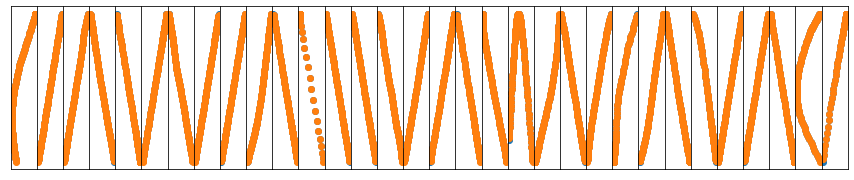

In [4]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch <= 5:
        continue
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

# Model Training

In [5]:
from models import LSTM
from tqdm import tqdm

val_iter = iter(val_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 2
hidden_size = 128
output_size = 2
inp_seq_len = 50

rnn = LSTM(input_size, hidden_size, output_size, device).cuda()
criterion = torch.nn.MSELoss()
criterion.to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

num_epochs = 50
print_every = 1000
val_every = 8
plot_every = 500 / (batch_sz/4)
train_loss = 0
val_loss = 0
train_losses = [-1]
val_losses = [-1]
# fig = plt.figure()

rnn.train()
for epoch in range(num_epochs):
    current_loss = 0
    val_iter = iter(val_loader)
    for s_num, (x, y) in tqdm(enumerate(train_loader), \
                              "val_loss: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], train_losses[-1], epoch)):
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
        
        opt.zero_grad()
        loss = 0
        
        y_hat = rnn(x)
        loss = criterion(y_hat, y)
        
        loss.backward()
        opt.step()
        
        # Validate every so often
        if s_num % val_every == 0:
            with torch.no_grad():
                rnn.eval()
                vx, vy = next(val_iter)
                vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                vy_hat = rnn(vx)
                val_loss += criterion(vy_hat, vy)
                del vx
                del vy
                rnn.train()
        
        # Print losses every so often
#         if s_num % display_every == 0:
#             with torch.no_grad():
#                 show_sample_batch((y[:4].cpu(), y_hat[:4].cpu()))
#                 rnn.eval()
#                 vx, vy = next(val_iter)
#                 vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
#                 vy_hat = rnn(vx)
#                 val_losses.append(criterion(vy_hat, vy))
#                 show_sample_batch((vy[:4].cpu(), vy_hat[:4].cpu()))
#                 del vx
#                 del vy
#                 rnn.train()
        
        # Keep track of average losses
        current_loss += loss.item()
        if s_num != 0 and s_num % plot_every == 0:
            with torch.no_grad():
                train_losses.append(current_loss / plot_every)
                current_loss = 0
                val_losses.append(val_loss / plot_every)
                val_loss = 0
                
        del x
        del y
    scheduler.step()
#     scheduler.step(val_losses[-1])
        

val_loss: -1.000, train_loss: -1.000, epoch #0: 300it [00:03, 78.27it/s]
val_loss: 406.725, train_loss: 1768.859, epoch #1: 300it [00:03, 78.98it/s]
val_loss: 251.920, train_loss: 970.450, epoch #2: 300it [00:03, 82.52it/s]
val_loss: 193.474, train_loss: 592.159, epoch #3: 300it [00:03, 84.13it/s]
val_loss: 165.819, train_loss: 359.162, epoch #4: 300it [00:03, 81.32it/s]
val_loss: 178.028, train_loss: 246.927, epoch #5: 300it [00:03, 81.84it/s]
val_loss: 165.910, train_loss: 172.276, epoch #6: 300it [00:03, 82.88it/s]
val_loss: 166.521, train_loss: 128.183, epoch #7: 300it [00:03, 80.81it/s]
val_loss: 193.203, train_loss: 101.210, epoch #8: 300it [00:03, 80.89it/s]
val_loss: 139.387, train_loss: 72.888, epoch #9: 300it [00:03, 83.84it/s]
val_loss: 141.299, train_loss: 56.279, epoch #10: 300it [00:03, 80.40it/s]
val_loss: 159.222, train_loss: 47.102, epoch #11: 300it [00:03, 78.24it/s]
val_loss: 175.866, train_loss: 31.294, epoch #12: 300it [00:03, 80.38it/s]
val_loss: 173.930, train_lo

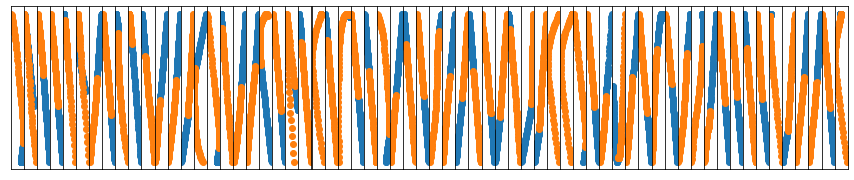

In [6]:
with torch.no_grad():
    rnn.eval()
    x, y = next(iter(val_loader))
    x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
    y_hat = rnn(x[:, :inp_seq_len])
    show_sample_batch((x[:, :inp_seq_len].cpu(), y_hat.cpu()))

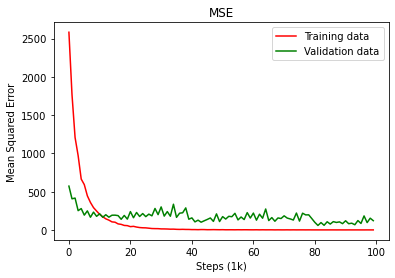

In [9]:
plt.figure(1)
plt.plot(range(len(train_losses[1:])), train_losses[1:],'-r', label="Training data")
plt.plot(range(len(val_losses[1:])), val_losses[1:],'-g', label="Validation data")
plt.gca().set_xlabel("Steps (1k)")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().set_title("MSE")
plt.legend()
plt.show()

# plt.figure(1)
# plt.plot(range(len(val_losses[1:])), val_losses[1:],'-g', label="Validation data")
# plt.gca().set_xlabel("Steps (1k)")
# plt.gca().set_ylabel("Mean Squared Error")
# plt.gca().set_title("Cross Validation Error")
# plt.legend()
# plt.show()

# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel("Steps (1k)")
# ax1.set_ylabel("Validation Error", color=color)
# ax1.plot(range(len(val_losses[1:])), val_losses[1:], color=color, label="Validation data")
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim([0, 850000])


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Train Error', color=color)  # we already handled the x-label with ax1
# ax2.plot(range(len(train_losses[1:])), train_losses[1:],color=color, label="Training data")
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

# Examining the submission format

In [ ]:
import pandas as pd

In [ ]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from prediction import get_traj_pred

In [ ]:
num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])

for city_name in cities:

    print("Processing city", city_name)
    
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)

    test_pred_arr = np.random.rand(test_traj_in.shape[0], 60, 2)
    print(test_pred_arr.shape)
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]

In [ ]:
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/Neelay_test_1.csv', index=None)